#  Time Series Prediction(LSTM)

In [3]:
#importing the required libraries
import streamlit as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt
import ccxt

### 1.Loading the financial data(web scraping)

In [4]:

# Initialize the Binance exchange
exchange = ccxt.binance()  # You can choose a different exchange if needed

# Specify the trading pair and timeframe
symbol = 'BTC/USDT'  # For BTC to USDT pair
timeframe = '1d'     # Daily timeframe

# Fetch OHLCV data
ohlcv = exchange.fetch_ohlcv(symbol, timeframe)

# Convert the data to a DataFrame
df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

# Display the DataFrame
print(df.head(10))

                open      high       low     close         volume
timestamp                                                        
2022-05-10  30074.23  32658.99  29730.40  31017.10  165532.003110
2022-05-11  31017.11  32162.59  27785.00  29103.94  207063.739278
2022-05-12  29103.94  30243.00  26700.00  29029.75  204507.263138
2022-05-13  29029.74  31083.37  28751.67  29287.05   97872.369570
2022-05-14  29287.05  30343.27  28630.00  30086.74   51095.878630
2022-05-15  30086.74  31460.00  29480.00  31328.89   46275.669120
2022-05-16  31328.89  31328.90  29087.04  29874.01   73082.196580
2022-05-17  29874.01  30788.37  29450.38  30444.93   56724.133070
2022-05-18  30444.93  30709.99  28654.47  28715.32   59749.157990
2022-05-19  28715.33  30545.18  28691.38  30319.23   67877.364150


### 2.Preparing the data(Data Pre-processing)

In [5]:
#removing unnecessary coloumns
df = df.reset_index()


In [6]:
df.head()

,timestamp,open,high,low,close,volume
0,2022-05-10,30074.23,32658.99,29730.40,31017.10,165532.003110
1,2022-05-11,31017.11,32162.59,27785.00,29103.94,207063.739278
2,2022-05-12,29103.94,30243.00,26700.00,29029.75,204507.263138
3,2022-05-13,29029.74,31083.37,28751.67,29287.05,97872.369570
4,2022-05-14,29287.05,30343.27,28630.00,30086.74,51095.878630


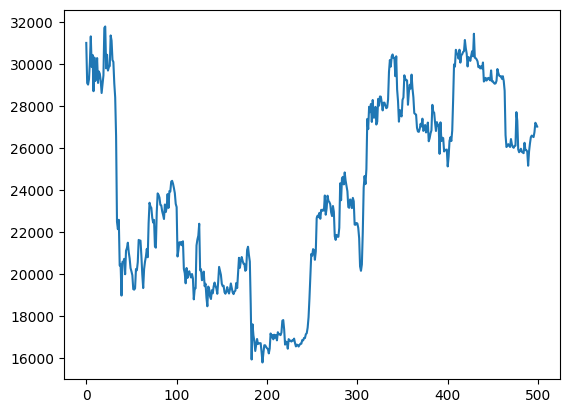

In [7]:
plt.plot(df.close)

In [8]:
df1 = df.reset_index()['close']

In [9]:
df1.shape

(500,)

### 3.Downscaling the data (MinMax scaler)

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [11]:
df1.shape

(500, 1)

In [12]:
df1

array([[0.95106416],
       [0.83163907],
       [0.82700791],
       [0.84306934],
       [0.89298834],
       [0.97052701],
       [0.87970911],
       [0.91534762],
       [0.80738026],
       [0.90750105],
       [0.83769847],
       [0.85293279],
       [0.90592238],
       [0.83196429],
       [0.86601164],
       [0.85899343],
       [0.83771969],
       [0.80204185],
       [0.82710654],
       [0.85437101],
       [0.9958289 ],
       [1.        ],
       [0.87545311],
       [0.91582765],
       [0.86886   ],
       [0.87908675],
       [0.88253063],
       [0.97328672],
       [0.95782019],
       [0.90035612],
       [0.89443593],
       [0.83088625],
       [0.78923891],
       [0.67374584],
       [0.41861577],
       [0.39670532],
       [0.42462773],
       [0.28839526],
       [0.29260881],
       [0.19909799],
       [0.29917508],
       [0.29916821],
       [0.30850856],
       [0.26259461],
       [0.3326419 ],
       [0.34060457],
       [0.35642878],
       [0.328

### 4.Splitting the dataset into train and test split

In [13]:
training_size = int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [14]:
training_size,test_size

(325, 175)

In [15]:
#converting an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[ i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [16]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [17]:
print(X_train.shape), print(y_train.shape)

(224, 100)
(224,)


(None, None)

In [18]:
print(X_test.shape), print(y_test.shape)

(74, 100)
(74,)


(None, None)

In [19]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

### 5.LSTM model

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM 

In [21]:
model = Sequential()
model.add(LSTM(units = 50,activation = 'tanh', return_sequences = True,
              input_shape = (100,1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 60,activation = 'tanh', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80,activation = 'tanh'))
model.add(Dropout(0.5))


model.add(Dense(units = 1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_2 (LSTM)               (None, 80)                45120     
                                                                 
 dropout_2 (Dropout)         (None, 80)                0         
                                                                 
 dense (Dense)               (None, 1)                 8

In [23]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=50,batch_size=64,verbose=1)

Epoch 1/50
4/4 [==============================] - 9s 807ms/step - loss: 0.0563 - val_loss: 0.0256
Epoch 2/50
4/4 [==============================] - 1s 284ms/step - loss: 0.0261 - val_loss: 0.0302
Epoch 3/50
4/4 [==============================] - 1s 278ms/step - loss: 0.0214 - val_loss: 0.0442
Epoch 4/50
4/4 [==============================] - 1s 289ms/step - loss: 0.0174 - val_loss: 0.0043
Epoch 5/50
4/4 [==============================] - 1s 290ms/step - loss: 0.0177 - val_loss: 0.0057
Epoch 6/50
4/4 [==============================] - 1s 291ms/step - loss: 0.0149 - val_loss: 0.0128
Epoch 7/50
4/4 [==============================] - 1s 304ms/step - loss: 0.0168 - val_loss: 0.0090
Epoch 8/50
4/4 [==============================] - 1s 309ms/step - loss: 0.0153 - val_loss: 0.0060
Epoch 9/50
4/4 [==============================] - 1s 282ms/step - loss: 0.0154 - val_loss: 0.0036
Epoch 10/50
4/4 [==============================] - 1s 287ms/step - loss: 0.0135 - val_loss: 0.0034
Epoch 11/50
4/4 [==

### 6.Tesing our model on testdata

In [24]:
#Prediction and Performance Matrix
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

3/3 [==============================] - 2s 54ms/step


In [25]:
#Upscaling the data
#back to orirginal form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [26]:
test_predict

array([[30561.521],
       [30734.451],
       [30914.135],
       [31119.266],
       [31311.002],
       [31580.434],
       [31785.268],
       [31877.889],
       [31849.814],
       [31716.508],
       [31489.105],
       [31219.715],
       [30946.9  ],
       [30719.975],
       [30554.047],
       [30486.836],
       [30421.814],
       [30346.342],
       [30279.67 ],
       [30221.67 ],
       [30188.684],
       [30188.857],
       [30211.188],
       [30240.715],
       [30315.768],
       [30374.53 ],
       [30396.773],
       [30370.83 ],
       [30299.945],
       [30201.477],
       [30106.443],
       [30086.398],
       [30125.47 ],
       [30187.58 ],
       [30244.6  ],
       [30281.293],
       [30279.414],
       [30254.62 ],
       [30194.838],
       [30064.143],
       [29677.072],
       [29036.271],
       [28273.803],
       [27540.768],
       [26942.736],
       [26535.658],
       [26370.027],
       [26408.129],
       [26585.842],
       [26835.713],


In [27]:
# RMSE performance metrics for training dataset
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

20891.310020347042

In [28]:
# RMSE for test data
math.sqrt(mean_squared_error(y_test,test_predict))

29079.12909293648

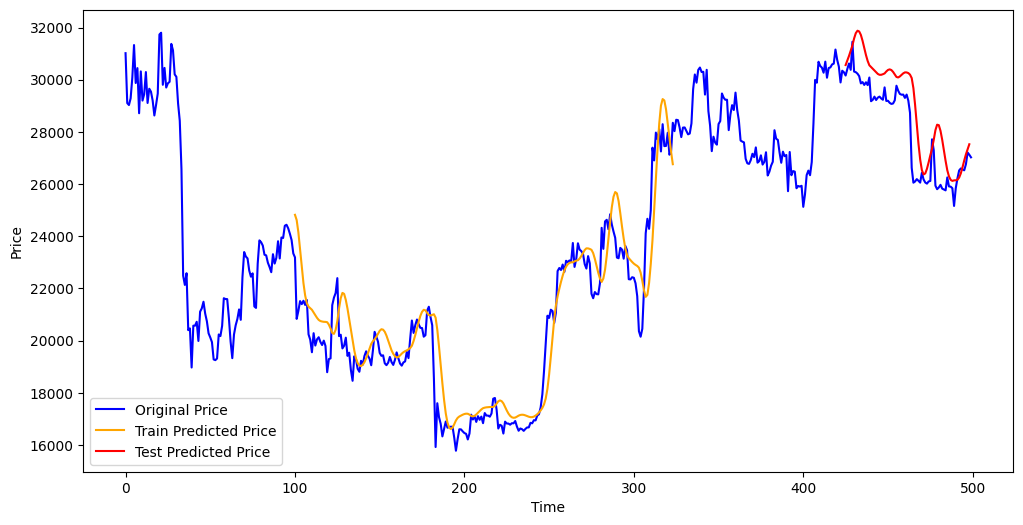

In [29]:
# Plotting 
plt.figure(figsize=(12,6)) 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.xlabel('Time')
plt.ylabel('Price')
plt.plot(scaler.inverse_transform(df1),'b',label ='Original Price')
plt.plot(trainPredictPlot,'orange',label ='Train Predicted Price')
plt.plot(testPredictPlot,'r',label='Test Predicted Price')
plt.legend()
plt.show()

### 7.Predicting future 30 days price

In [30]:
tlen=len(test_data)
tlen

175

In [31]:
x_input=test_data[tlen-100:].reshape(1,-1)
x_input.shape

(1, 100)

In [32]:
#storing data collected into list
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [33]:
temp_input

[0.5834866336865432,
 0.612818552099752,
 0.6594179060222538,
 0.6701540286209211,
 0.6591039186004777,
 0.6905888044445136,
 0.7819535261162005,
 0.8871923719159163,
 0.8803901434167198,
 0.9305519749059754,
 0.9204975108850013,
 0.9164543766288489,
 0.9043025015995882,
 0.9307979213158757,
 0.8924059364222288,
 0.9154961843973846,
 0.9170374069507952,
 0.9241473805771003,
 0.9260906069070991,
 0.9597471870659655,
 0.9354215889761075,
 0.9190855038312085,
 0.8810462085862765,
 0.9090909658390425,
 0.9053412194322634,
 0.8976057678802727,
 0.913265188283213,
 0.9264070912467424,
 0.9112944958566769,
 0.9783510978635748,
 0.9070503597122301,
 0.905646467641505,
 0.902055275519281,
 0.896188142761279,
 0.8787802556219668,
 0.8819063967914604,
 0.8750891867850623,
 0.8814388489208635,
 0.8747146491050111,
 0.8928016979041495,
 0.8361684795330764,
 0.8394400661683235,
 0.8471212097567065,
 0.8390574135052045,
 0.8447603739134506,
 0.8471798873265814,
 0.8426972955258354,
 0.839648558810218

In [34]:
#logic for prediction
from numpy import array

lst_output=[]
n_steps = 100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else :
        x_input = x_input.reshape((1,n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
        

print(lst_output)

[0.74966174]
101
1 day input [0.61281855 0.65941791 0.67015403 0.65910392 0.6905888  0.78195353
 0.88719237 0.88039014 0.93055197 0.92049751 0.91645438 0.9043025
 0.93079792 0.89240594 0.91549618 0.91703741 0.92414738 0.92609061
 0.95974719 0.93542159 0.9190855  0.88104621 0.90909097 0.90534122
 0.89760577 0.91326519 0.92640709 0.9112945  0.9783511  0.90705036
 0.90564647 0.90205528 0.89618814 0.87878026 0.8819064  0.87508919
 0.88143885 0.87471465 0.8928017  0.83616848 0.83944007 0.84712121
 0.83905741 0.84476037 0.84717989 0.8426973  0.83964856 0.86922081
 0.83676212 0.83723841 0.83226642 0.8296534  0.83067027 0.83832582
 0.87324272 0.86148036 0.85360009 0.85174488 0.85200331 0.84411742
 0.85205075 0.83763542 0.80832847 0.67679708 0.64125283 0.64412491
 0.64974173 0.64580471 0.64137767 0.66489365 0.64912124 0.64162799
 0.63896628 0.64423477 0.64537274 0.74502099 0.7190312  0.6341853
 0.62571264 0.62973642 0.63608483 0.62702165 0.62490426 0.62289736
 0.65379984 0.63229514 0.6317402  0

In [35]:
day_new=np.arange(1,101)
day_pred = np.arange(101,131)

In [36]:
datalen=len(df1)

<function matplotlib.pyplot.show(close=None, block=None)>

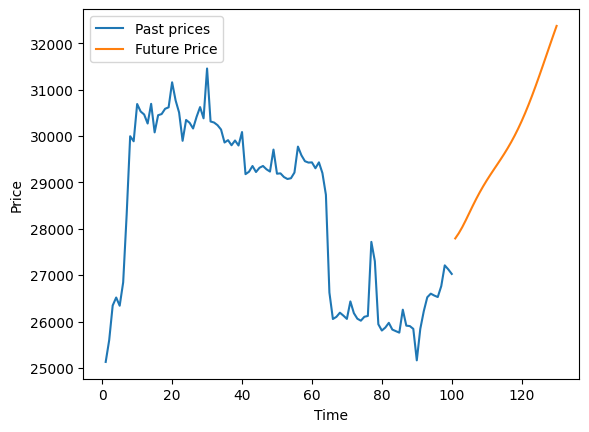

In [37]:
plt.xlabel('Time')
plt.ylabel('Price')
plt.plot(day_new,scaler.inverse_transform(df1[datalen-100:]),label='Past prices')
plt.plot(day_pred,scaler.inverse_transform(lst_output),label='Future Price')
plt.legend()
plt.show